In [60]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
import argparse
import os
import SynClock as SC

In [342]:
import numpy as np
import cv2
import math
import random

def truefalse(p):
	return random.random() < p

def intminmax(mi, ma):
	return random.choice(range(mi, ma+1))

def minmax(mi, ma):
	return np.random.uniform(mi,ma)

def rand_colour(p_gray=0, p_light=0, p_dark=0, p_red=0):
	xmin = 0; xmax = 255;
	gray = random.random() < p_gray
	if gray:
		x = random.choice(range(xmin,xmax))
		return (x, x, x)
	light = random.random() < p_light
	if light: 
		xmin  = 200;
		x = random.choice(range(xmin,xmax))
		return (x, x, x)
	dark = random.random() < p_dark
	if dark: 
		xmax = 100;
		x = random.choice(range(xmin,xmax))
		return (x, x, x)
	
	xmin = 50; ymin = 50; zmin = 50;
	xmax = 200; ymax = 200; zmax = 200;
	red = random.random() < p_red
	if red:
		xmin = 0; ymin = 0; zmin = 127;
		xmax = 100; ymax = 100; zmax = 255;
	x = random.choice(range(xmin,xmax))
	y = random.choice(range(ymin,ymax))
	z = random.choice(range(zmin,zmax))
	return (x, y, z)

def get_coordinates(cx, cy, r, scale, back_scale, a):
	x1 = (cx + scale*r * np.cos(a * math.pi/180)).astype(int)
	y1 = (cy + scale*r * np.sin(a * math.pi/180)).astype(int)
	x2 = (cx + back_scale*r * np.cos(a * math.pi/180)).astype(int)
	y2 = (cy + back_scale*r * np.sin(a * math.pi/180)).astype(int)
	return (x1, y1), (x2, y2)

def draw_line(img, source, dest, colour, thickness, arrow=False, arrow_scale=None, tip_length=None, rand=False):
	img = cv2.line(img, source, dest, colour, thickness)
	x1, y1 = source
	x2, y2 = dest

	return img

def draw_random_lines(img, cx, cy, r, R, num=3):

	for _ in range(num):
		r1 = intminmax(r,R)
		r2 = intminmax(r,R)
		r3 = intminmax(r,R)
		theta1 = minmax(0, 360)
		theta2 = minmax(0, 360)
		theta3 = minmax(0, 360)
		colour = (0,0,0)
		thickness = intminmax(1,2)

		x1 = (cx + r1 * np.cos(theta1 * math.pi/180)).astype(int)
		y1 = (cy + r1 * np.sin(theta1 * math.pi/180)).astype(int)
		x2 = (cx + r2 * np.cos(theta2 * math.pi/180)).astype(int)
		y2 = (cy + r2 * np.sin(theta2 * math.pi/180)).astype(int)
		x3 = (cx + r3 * np.cos(theta3 * math.pi/180)).astype(int)
		y3 = (cy + r3 * np.sin(theta3 * math.pi/180)).astype(int)
        
		triangle = truefalse(0.5)
		if triangle:
			cv2.line(img, (x1, y1), (x2, y2), colour, thickness)
			cv2.line(img, (x2, y2), (x3, y3), colour, thickness)
			cv2.line(img, (x3, y3), (x1, y1), colour, thickness)
		else:
			img_shadow = cv2.line(img, (x1, y1), (x2, y2), colour, thickness)
	return img


def gen_clock(use_artefacts=True):
	#hyperparameters:
	#canvas
	H = 300
	W = 300
	h = 250 #intminmax(384, 512)
	w = h 
	canvas_background_colour = (0, 0, 0)
	hmax = 0

	#clock shape
	clock_center_coordinates = (h//2, w//2)
	clock_border_thickness = intminmax(0, 1)
	clock_radius = (min(h,w)//2 - clock_border_thickness//2 -1)
	clock_background_colour = (255,255,255) #if truefalse(0.7) else rand_colour(p_gray=0.2)


	#hands
	use_second_hand = truefalse(0.0)
	time_hour = intminmax(0, 12)
	time_minute = intminmax(0, 60)
	time_second = intminmax(0, 60)


	min_scale = minmax(0.5, 1)
	min_back_scale = 0 if truefalse(0.3) else minmax(-0.15, 0.15)
	min_colour = (0,0,0)
	min_thickness = intminmax(1,3)

	hr_scale = minmax(0.3, min_scale)
	hr_back_scale = 0 if truefalse(0.3) else minmax(-0.15, 0.15)
	hr_colour = (0,0,0)
	hr_thickness = intminmax(1,3)

	#circle
	circle_radius = intminmax(1,5)
	circle_colour = (0,0,0)

	#create background
	img = np.zeros((h, w, 3), np.uint8)
	img[:] = canvas_background_colour

	#random lines
	if use_artefacts:
		num_random_lines = intminmax(0, 5)


	#create clock
	img = cv2.circle(img, clock_center_coordinates, clock_radius, clock_background_colour, cv2.FILLED)
	img = cv2.circle(img, clock_center_coordinates, clock_radius, clock_border_thickness)


	#create ticks
	cy, cx = clock_center_coordinates
	r = clock_radius
	a = np.arange(60)*6
	acos = np.cos(a * math.pi/180)
	asin = np.sin(a * math.pi/180)

	#hands

	second = time_second
	a_second = second * 6 - 90

	minute = time_minute + second/60
	a_minute = minute * 6 - 90
	source, dest = get_coordinates(cx, cy, r, min_scale, min_back_scale, a_minute)
	img = draw_line(img, source, dest, min_colour, min_thickness)

	hour = time_hour + minute/60
	a_hour = hour * 30 - 90
	source, dest = get_coordinates(cx, cy, r, hr_scale, hr_back_scale, a_hour)
	img = draw_line(img, source, dest, hr_colour, hr_thickness)
	
	if use_artefacts:
		img = draw_random_lines(img, cx, cy, circle_radius, r, num=num_random_lines)

	#circle
	img = cv2.circle(img, clock_center_coordinates, circle_radius, circle_colour, cv2.FILLED)

	return img, time_hour, time_minute

1 : 49


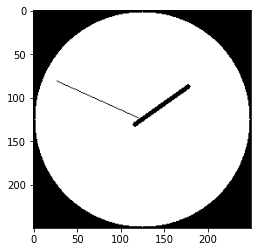

In [344]:
img, hour, minute= gen_clock(use_artefacts=True)
print(hour,":", minute)
plt.imshow(img)

In [355]:
import os
import time
import torch
import einops
import random
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from tensorboardX import SummaryWriter
from datetime import datetime
from argparse import ArgumentParser
from torch.utils.data import DataLoader
from utils import warp, update_train_log, write_train_log, update_eval_log, write_eval_log

dt_string = datetime.now().strftime("%m_%d_%H_%M")
writer = SummaryWriter(logdir='../logs/{}'.format(dt_string))

# DATASET
trn_dataset = gen_clock(use_artefacts=True)
trn_loader = DataLoader(trn_dataset, batch_size=30, shuffle=True)


In [356]:
trn_loader

In [362]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import random
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import xception
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: SystemError: <built-in method __contains__ of dict object at 0x7f7aaae6e780> returned a result with an error set